<a href="https://colab.research.google.com/github/VindhyaSRajan/Guided-Research/blob/master/Copy_of_Guided_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

#Imports and Installations

In [2]:
#installing all the libraries needed for the task

import pandas as pd
import json
import nltk
from pandas.io.json import json_normalize
nltk.download('stopwords')
nltk.download('punkt')
import re  
from nltk.corpus import stopwords
stops1 = set(stopwords.words("english"))
import pickle
from torch.utils.data.sampler import Sampler  
import time
import ipywidgets
import traitlets
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
processed_df = pd.read_pickle('/content/drive/My Drive/processed_df_500k.pkl') #Path to the Pickled Processed DF (500k data as Colab crashes with 1M data)

In [4]:
processed_df.sample(10)

,Ingredients,Recipe_id,Ingredient_Numeric,Recipe_id_numeric
362026,"[butter, sour cream, vinegar, honey, salt, let...",Lighter Chefs Salad,"[6458, 10884, 14639, 9812, 2982, 20631, 1718, ...",14
216684,"[beef, onion, green bean, mashed potato, chedd...",Mommas Shepherds Pie,"[4337, 10952, 989, 27734, 34319]",0
420141,"[chili pepper, cheddar cheese, green, cream ch...",Mexican Roll Ups,"[14034, 34319, 989, 5161, 10884, 8212]",0
71527,"[mango, yogurt, milk, sugar, pistachio]",Mango Lassi Authentic Indian-Style Mango Smoothie,"[21638, 19302, 4177, 3191, 56156]",8
216630,"[flour, brown sugar, cinnamon, butter, baking ...",Banana Bread with Streusel Topping,"[8212, 1042, 17773, 6458, 10057, 3191, 5161, 6...",7
70515,"[canola oil, garlic, ginger, bean, carrot, cel...",Asian Pork Meatloaf with Red Wine-Mushroom Gravy,"[40744, 9005, 13261, 11239, 20786, 24334, 1095...",0
473893,"[yeast, water, flour, onion, butter, egg]",Dill Onion Buttermilk Bread,"[21043, 430, 8212, 10952, 6458, 6593]",7
338136,"[oil, pork, salt, onion, cumin, coriander, ore...",New Mexican Chile Verde,"[316, 7635, 2982, 10952, 32428, 43382, 37801, ...",0
194478,"[grand marnier, lemon juice, tea]",Bayou Zinger,"[1063, 9311, 4325]",0
398331,"[basil, garlic, pine nuts, salt, olive oil, pa...",Vegetarian Eggs Benedict,"[13741, 9005, 7340, 2982, 6952, 30580, 1718, 3...",0


In [5]:
max(processed_df.Recipe_id_numeric)

32

In [0]:
# Let us load the word2vec embeddings which can be used for our pretrained network
# ! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [0]:
# !gzip -d GoogleNews-vectors-negative300.bin.gz

In [6]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-04-30 07:46:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-30 07:46:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-30 07:46:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [7]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [8]:
!pwd

/content


In [9]:
from gensim.test.utils import datapath
from gensim.scripts.glove2word2vec import glove2word2vec
glove_file = datapath('/content/glove.6B.100d.txt')
with open('/content/glove.100d.w2v', mode='wb+') as dest_file:
    glove2word2vec(glove_file, dest_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [10]:
import gensim
# pretrained_embedding = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
pretrained_embedding = gensim.models.KeyedVectors.load_word2vec_format('/content/glove.100d.w2v')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [11]:
pretrained_embedding.vectors.shape

(400000, 100)

In [0]:
# At this point, it is possible to work on trimmed_data first
# which is basically all the categories that we already know of
trimmed_df = processed_df.drop(processed_df[processed_df.Recipe_id_numeric == 0].index)
# trimmed_df = processed_df
trimmed = True

In [13]:
trimmed_df.shape

(166659, 4)

#### These are the Vocabularies that are loaded via the files

In [0]:
# TODO: Come up with better comments. This file should no longer be needed
# since the vocabulary is loaded using pretrained embedding
with open('/content/drive/My Drive/vocab_combined_500k.pkl','rb') as file:
    recipe_vocabulary_file = pickle.load(file)
    ingredient_vocabulary = pickle.load(file)

In [15]:
#for the 500k case ONLY as The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. 
indexNames = trimmed_df[ trimmed_df['Recipe_id_numeric'] == 12 ].index
 
# Delete these row indexes from dataFrame
trimmed_df.drop(indexNames , inplace=True)
trimmed_df.shape

(166658, 4)

In [0]:
from sklearn.model_selection import train_test_split
# replace processed_df with trimmed_df
df_train, df_test = train_test_split(trimmed_df, test_size=0.1,
                  random_state=42, stratify=trimmed_df.Recipe_id_numeric)

## Neural Network Part

In [0]:
# Some constants
batch_size = 16
num_epoch = 10

In [0]:
from RecipeData import collate_fn
from RecipeData import RecipeData
import torch
import torch.nn as nn

In [0]:
class_sample_count_train = df_train.Recipe_id_numeric.value_counts().sort_index()
# Similar operation not done on `Val` dataset since it is as good as seeing entirely 
# new data. So, all operations are done on the training set

In [0]:
# Class is imbalanced so let's handle this by weighted sampling
# weights = 1 / torch.Tensor(class_sample_count_train)
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size)
train_dataset = RecipeData(df_train)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           collate_fn=collate_fn,
                                           drop_last=True,
                                           shuffle=True
                                           )

In [0]:
test_dataset = RecipeData(df_test)
# weights = 1 / torch.Tensor(class_sample_count_val)
# sampler = torch.utils.data.sampler.WeightedRandomSampler()
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, # of the batch_size
                                              batch_size=batch_size,
                                              collate_fn=collate_fn,
                                              drop_last=True,
                                              # sampler=sampler
                                               )

In [22]:
train_dataset[0]

(tensor([ 3200,  3200,  6952, 13056,  9005,   298,  2982,  4298]),
 tensor(26),
 'Caribbean Chicken Breast',
 ['orange juice',
  'orange zest',
  'olive oil',
  'lime juice',
  'garlic',
  'white pepper',
  'salt',
  'chicken breast'])

In [23]:
# Moving things to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
from Networks import EmbeddingNetwork
from Networks import ClassificationNetwork

In [25]:
sorted(df_train.Recipe_id_numeric.unique()) == sorted(df_test.Recipe_id_numeric.unique())

True

In [0]:
# These are some constants that I am just copying here
# These need to be updated based on the files
ingredient_vocabulary = 1267     #1310 #Changed from 1152
# recipe_vocabulary = 33
vocab_size = ingredient_vocabulary + 1
num_recipes = max(df_train.Recipe_id_numeric.unique()) + 1
hidden_dim = 128 #32

In [27]:
num_recipes

33

In [0]:
# TODO: Increase the hidden_dim to make the model more powerful
embedding_model = EmbeddingNetwork(vocab_size=vocab_size, 
                                   hidden_dim=hidden_dim,
                                   dropout=0,
                                   bidirectional=True,
                                   glove=pretrained_embedding)

In [0]:
model = ClassificationNetwork(embedding_model=embedding_model, 
                              hidden_dim=hidden_dim,
                              num_classes=num_recipes,
                              p=0.5,
                              num_directions=2)

### I did not put hidden state on cuda and that was an issue. So, it has been corrected

In [30]:
counter = -1 # A dummy variable to make keeping track of Summary Writers easier
embedding_model.to(device)
model.to(device)

ClassificationNetwork(
  (embedding_model): EmbeddingNetwork(
    (embedding): Embedding(400000, 100)
    (GRU): GRU(100, 128, num_layers=2, bidirectional=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (bn): BatchNorm1d(66, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (linear_first): Linear(in_features=128, out_features=66, bias=True)
  (linear): Linear(in_features=66, out_features=33, bias=True)
)

## Put loss function and categories

In [31]:
class_sample_count_train

1     16258
2      4904
3      1347
4      2687
5      1202
6       289
7     10261
8      1948
9       556
10     3676
11     4351
13     2231
14    26017
15     1060
16      457
17      377
18     3763
19     3719
20      789
21     3704
22     6500
23     5585
24     4540
25      186
26    29860
27     6409
29     1885
30      299
31     3867
32     1265
Name: Recipe_id_numeric, dtype: int64

In [0]:
# Some class labels are missing eg Pancakes. This is a way to handle that issue basically.
# We would go through the value counts and assign weights using a for loop
weight_array = np.ones(num_recipes)
for key, value in class_sample_count_train.items():
    weight_array[key] = value

In [33]:
weight_array

array([1.0000e+00, 1.6258e+04, 4.9040e+03, 1.3470e+03, 2.6870e+03,
       1.2020e+03, 2.8900e+02, 1.0261e+04, 1.9480e+03, 5.5600e+02,
       3.6760e+03, 4.3510e+03, 1.0000e+00, 2.2310e+03, 2.6017e+04,
       1.0600e+03, 4.5700e+02, 3.7700e+02, 3.7630e+03, 3.7190e+03,
       7.8900e+02, 3.7040e+03, 6.5000e+03, 5.5850e+03, 4.5400e+03,
       1.8600e+02, 2.9860e+04, 6.4090e+03, 1.0000e+00, 1.8850e+03,
       2.9900e+02, 3.8670e+03, 1.2650e+03])

In [34]:
weights = weight_array/1000
class_weights = torch.as_tensor(weights, dtype=torch.float32) 
class_weights = class_weights.to(device)
print(class_weights)
len(class_weights)

tensor([1.0000e-03, 1.6258e+01, 4.9040e+00, 1.3470e+00, 2.6870e+00, 1.2020e+00,
        2.8900e-01, 1.0261e+01, 1.9480e+00, 5.5600e-01, 3.6760e+00, 4.3510e+00,
        1.0000e-03, 2.2310e+00, 2.6017e+01, 1.0600e+00, 4.5700e-01, 3.7700e-01,
        3.7630e+00, 3.7190e+00, 7.8900e-01, 3.7040e+00, 6.5000e+00, 5.5850e+00,
        4.5400e+00, 1.8600e-01, 2.9860e+01, 6.4090e+00, 1.0000e-03, 1.8850e+00,
        2.9900e-01, 3.8670e+00, 1.2650e+00], device='cuda:0')


33

In [0]:
class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True, class_weights=None):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu
        self.ce = nn.CrossEntropyLoss(weight=class_weights)

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, outputs, labels, gamma=3):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        class_labels = labels
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: 
          classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size # Thus average value
        loss = gamma * loss + self.ce(outputs, class_labels)
        return loss

In [0]:
lr = 1e-4
# Let us go ahead and reweight the loss function
# weight=weights
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion = CenterLoss(num_classes=num_recipes, feat_dim=hidden_dim, class_weights=class_weights)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [0]:
def put_elements_to_device(a,b,c,device):
    return a.to(device), b.to(device), c.to(device)

In [38]:
!pip install -q tb-nightly
# Load the TensorBoard notebook extension
%load_ext tensorboard

     |████████████████████████████████| 2.9MB 2.8MB/s 


In [0]:
from torch.utils.tensorboard import SummaryWriter
counter = counter + 1
writer = SummaryWriter('RNN-train/'+str(counter))

In [40]:
# Not same since we are dropping some terms which do not match up
N_train = len(train_data_loader) * batch_size
N_test = len(test_data_loader) * batch_size
print("training set size is {}".format(N_train))
print("test set size is {}".format(N_test))

training set size is 149984
test set size is 16656


In [0]:
save_model_name = "./lstm_model_epoch-{}"

In [42]:
for epoch in range(num_epoch):
    running_loss = 0
    correct = 0
    total = 0
    model.train()
    for idx,(X,X_len,y,a,b) in enumerate(train_data_loader):
        # model.train()No batch norm used yet
        model.zero_grad()
        X, X_len, y = put_elements_to_device(a=X, b=torch.tensor(X_len), c=y, device=device)
        output_embedding = model.embedding_model(X, X_len)[0]
        outputs = model(X, X_len)
        loss = criterion(output_embedding, outputs, y)
        # loss = criterion(outputs, y)
        loss.backward(retain_graph=True)
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        running_loss += loss.item()
        total += X.size(0)
        correct += (predicted == y).sum().item()
    print('Accuracy of the network on the train samples: %d %%' % (
        100 * correct / total))
    # writer.add_scalar('Loss/train', running_loss/N_train, epoch)
    # validation set is still left to create
    # Now to test the validation set
    test_correct = 0
    test_total = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for idx2,(X,X_len,y,_,_) in enumerate(test_data_loader):
            X, X_len, y = put_elements_to_device(a=X, b=torch.tensor(X_len), c=y, device=device)
            output_embedding = model.embedding_model(X, X_len)[0] # Returns h_n
            outputs = model(X, X_len)
            loss = criterion(output_embedding, outputs, y)
            # loss = criterion(outputs, y)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += X.size(0)
            test_correct += (predicted == y).sum().item()
    # writer.add_scalar('Loss/test', test_loss/N_test, epoch)
    writer.add_scalars('loss_adjusted',
                       {'train':running_loss/(idx + 1), 'test':test_loss/(idx2 + 1)},
                       epoch)
    writer.add_scalars('accuracy_adjusted',
                       {'train':100 * correct/total, 'test':100 * test_correct/test_total},
                       epoch)
    print('Accuracy of the network on the test samples: %d %%' % (
        100 * test_correct / test_total))
    torch.save(model.state_dict(),save_model_name.format(epoch))    
    print("epoch {} complete".format(epoch))       

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha)


Accuracy of the network on the train samples: 49 %
Accuracy of the network on the test samples: 58 %
epoch 0 complete
Accuracy of the network on the train samples: 58 %
Accuracy of the network on the test samples: 60 %
epoch 1 complete
Accuracy of the network on the train samples: 60 %
Accuracy of the network on the test samples: 63 %
epoch 2 complete
Accuracy of the network on the train samples: 62 %
Accuracy of the network on the test samples: 65 %
epoch 3 complete
Accuracy of the network on the train samples: 63 %
Accuracy of the network on the test samples: 64 %
epoch 4 complete
Accuracy of the network on the train samples: 64 %
Accuracy of the network on the test samples: 65 %
epoch 5 complete
Accuracy of the network on the train samples: 65 %
Accuracy of the network on the test samples: 65 %
epoch 6 complete
Accuracy of the network on the train samples: 65 %
Accuracy of the network on the test samples: 66 %
epoch 7 complete
Accuracy of the network on the train samples: 66 %
Accur

In [0]:
# ! pip uninstall tensorboard
# ! pip install --force-reinstall tf-nightly-2.0-preview

In [43]:
# !pip install tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
%tensorboard --logdir RNN-train

##TSNE Portion

## Load the best model here

In [45]:
model_path = 'lstm_model_epoch-3'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [0]:
# Set to evaludation mode
model.eval()
model.cuda()
embedding_model = model.embedding_model

In [47]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from torch.utils.data import Sampler
class FirstKSampler(Sampler):
    def __init__(self, data_source, max_len=10000):
        self.data_source = data_source
        self.max_len = max_len

    def __iter__(self):
        return iter(range(self.max_len))

    def __len__(self):
        return self.max_len

In [49]:
# df_test.Recipe_id_numeric.value_counts()
subset_component = [1,10,7]
df_subset = df_test[df_test.Recipe_id_numeric.isin(subset_component)]
print(df_subset.Recipe_id_numeric.value_counts())
print(df_subset.Recipe_id.count())

1     1807
7     1140
10     408
Name: Recipe_id_numeric, dtype: int64
3355


In [0]:
# Running only for the first 500 samples
dabang_batch_size=10
data_dabang = RecipeData(df=df_test)#RecipeData(df=df_subset)
# train_sampler = FirstKSampler(data_source=data_dabang, max_len=500)
embed_data_loader = torch.utils.data.DataLoader(dataset=data_dabang, # of the batch_size
                                              batch_size=dabang_batch_size,
                                              collate_fn=collate_fn,
                                              drop_last=True,
                                            # sampler=train_sampler
                                               )

In [0]:
X_list = []
y_list = []
with torch.no_grad():
    for  idx,(X,X_len,y,_,_) in enumerate(embed_data_loader):
            X, X_len, y = put_elements_to_device(a=X, b=torch.tensor(X_len), c=y, device=device)
            for item in range(dabang_batch_size):
                value = embedding_model(X, X_len)[0][item]
                X_list.append(value.unsqueeze_(0))
                y_list.append(y[item].item())
            

In [0]:
X_combined = torch.cat(X_list,0)
X = X_combined.cpu().numpy()

In [0]:
target_ids = list(set(y_list))

In [54]:
target_ids #Willingly dropped UNK : 0 and Number 12 label. Number 28 label : Spring Roll not found

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32]

In [55]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000) #just changed it to 2 for future cells to run
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 16660 samples in 0.300s...
[t-SNE] Computed neighbors for 16660 samples in 24.495s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16660
[t-SNE] Computed conditional probabilities for sample 2000 / 16660
[t-SNE] Computed conditional probabilities for sample 3000 / 16660
[t-SNE] Computed conditional probabilities for sample 4000 / 16660
[t-SNE] Computed conditional probabilities for sample 5000 / 16660
[t-SNE] Computed conditional probabilities for sample 6000 / 16660
[t-SNE] Computed conditional probabilities for sample 7000 / 16660
[t-SNE] Computed conditional probabilities for sample 8000 / 16660
[t-SNE] Computed conditional probabilities for sample 9000 / 16660
[t-SNE] Computed conditional probabilities for sample 10000 / 16660
[t-SNE] Computed conditional probabilities for sample 11000 / 16660
[t-SNE] Computed conditional probabilities for sample 12000 / 16660
[t-SNE] Computed conditional probabilities for s

In [56]:
tsne_results.shape

(16660, 2)

In [0]:
df_subset = pd.DataFrame()
df_subset["y"] = y_list

<Figure size 432x360 with 0 Axes>

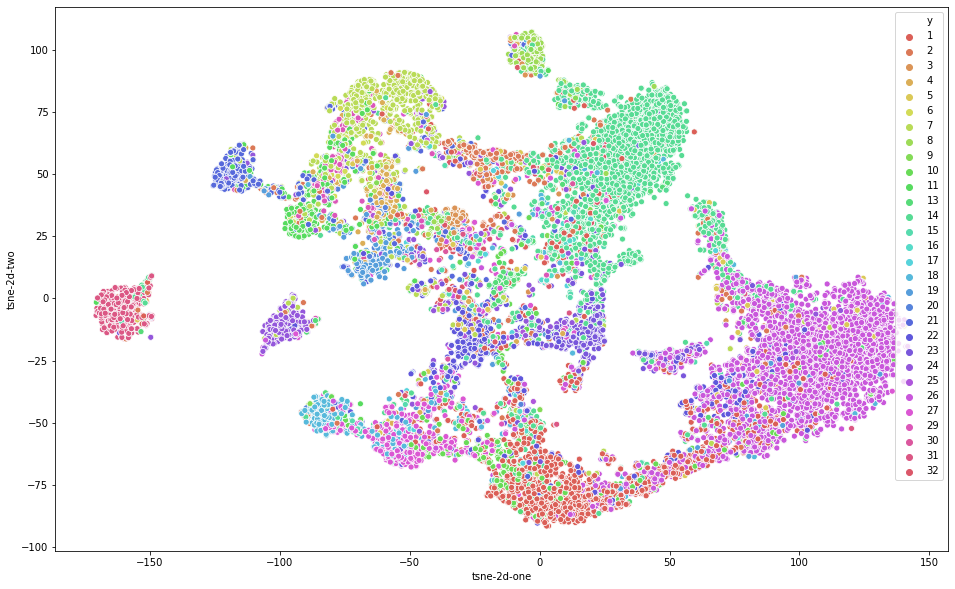

In [58]:
plt.figure(figsize=(6, 5))
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x = "tsne-2d-one", y = "tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(target_ids)),
    data=df_subset,
    legend="full",
    alpha=1.0
)
plt.savefig('./t-sne_500k_gamma3.png')

In [0]:
# Using EMbedding Projectors
writer.add_embedding(X, metadata=y_list)

In [60]:
df_train.iloc[0]

Ingredients           [orange juice, orange zest, olive oil, lime ju...
Recipe_id                                      Caribbean Chicken Breast
Ingredient_Numeric     [3200, 3200, 6952, 13056, 9005, 298, 2982, 4298]
Recipe_id_numeric                                                    26
Name: 101280, dtype: object

In [61]:
df_train['COUNTER']=1
group_data = df_train.groupby(['Recipe_id_numeric'])['COUNTER'].sum()
group_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Recipe_id_numeric
1     16258
2      4904
3      1347
4      2687
5      1202
6       289
7     10261
8      1948
9       556
10     3676
11     4351
13     2231
14    26017
15     1060
16      457
17      377
18     3763
19     3719
20      789
21     3704
22     6500
23     5585
24     4540
25      186
26    29860
27     6409
29     1885
30      299
31     3867
32     1265
Name: COUNTER, dtype: int64

In [62]:
correct = 0
total = 0
all_labels = []
all_predictions=[]
for idx,(X,X_len,y,recipe_name,_) in enumerate(test_data_loader):
    X, X_len, y = put_elements_to_device(a=X, b=torch.tensor(X_len), c=y, device=device)
    outputs = model(X,X_len)
    _, predicted = torch.max(outputs.data, 1)
    total += X.size(0)
    correct += (predicted == y).sum().item()
    all_labels.append(y)
    all_predictions.append(predicted)
print('Accuracy of the network on the test samples: %d %%' % (
        100 * correct / total))

Accuracy of the network on the test samples: 65 %


In [63]:
correct = 0
total = 0
all_labels = []
all_predictions=[]
for idx,(X,X_len,y,recipe_name,_) in enumerate(train_data_loader):
    X, X_len, y = put_elements_to_device(a=X, b=torch.tensor(X_len), c=y, device=device)
    outputs = model(X,X_len)
    _, predicted = torch.max(outputs.data, 1)
    total += X.size(0)
    correct += (predicted == y).sum().item()
    all_labels.append(y)
    all_predictions.append(predicted)
print('Accuracy of the network on the train samples: %d %%' % (
        100 * correct / total))

Accuracy of the network on the train samples: 65 %


In [0]:
from sklearn.metrics import f1_score,accuracy_score, confusion_matrix, classification_report

In [65]:
pred = torch.cat(all_predictions)
pred = pred.cpu().numpy()
all_lab = torch.cat(all_labels)
all_lab = all_lab.cpu().numpy()
print(pred.shape)
print(all_lab.shape)

(149984,)
(149984,)


In [66]:
f1_score(all_lab, pred, average='micro')

0.6577634947727757

In [67]:
f1_score(all_lab, pred, average='macro')

0.35018527209690664

In [0]:
# labels = list(set(data_train.labels_encoded))
cm = confusion_matrix(all_lab, pred)

In [69]:
from pprint import pprint
pprint(cm)

array([[11130,    12,     0,     7,     0,     0,   113,    38,     0,
           12,     7,     8,   892,     0,     0,     0,    11,    24,
            0,     1,   327,   156,    24,     0,  3131,   330,     0,
            0,    34,     0],
       [  117,  1445,     1,    12,     0,     0,   561,    17,     0,
            0,   143,     8,  1313,     0,     0,     0,    46,    68,
            0,   127,   248,    18,    75,     0,   492,   151,     0,
            0,    62,     0],
       [   50,    18,   214,     5,     0,     0,    50,    53,     0,
            0,    19,     0,   791,     0,     0,     0,    14,    31,
            0,     7,    14,     1,     4,     0,    37,    38,     0,
            0,     1,     0],
       [   88,    10,     0,   597,     0,     0,  1037,   116,     0,
            0,   152,     0,   238,     0,     0,     0,     5,   167,
            0,    37,   185,     3,     0,     0,    24,    27,     0,
            0,     1,     0],
       [   54,    66,     0,

In [0]:
def get_all_labels():
   labels = list(recipe_vocabulary_file.word_2_idx.keys()) 
   return labels

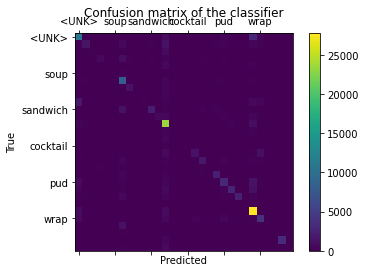

<Figure size 432x288 with 0 Axes>

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + get_all_labels())
ax.set_yticklabels([''] + get_all_labels())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('Confusion_matrix_of_the_classifier_500k_gamma3.png')

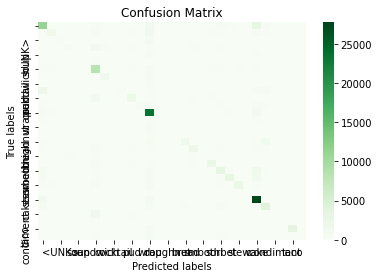

In [72]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([''] + get_all_labels());
ax.yaxis.set_ticklabels([''] + get_all_labels());
plt.savefig('Confusion_matrix_500k_gamma3.png')

In [73]:
print(classification_report(all_lab, pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.62      0.68      0.65     16257
           2       0.62      0.29      0.40      4904
           3       0.91      0.16      0.27      1347
           4       0.51      0.22      0.31      2687
           5       0.00      0.00      0.00      1202
           6       0.00      0.00      0.00       289
           7       0.53      0.81      0.64     10260
           8       0.73      0.69      0.71      1947
           9       0.00      0.00      0.00       556
          10       0.77      0.06      0.11      3676
          11       0.65      0.51      0.57      4351
          13       0.72      0.25      0.37      2231
          14       0.65      0.90      0.76     26016
          15       0.00      0.00      0.00      1060
          16       0.00      0.00      0.00       457
          17       0.00      0.00      0.00       377
          18       0.74      0.36      0.48      3763
          19       0.57    

## The best model has been chosen and we load vectors for everything else

In [74]:
# This is sloooowwww
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, # of the batch_size
                                              batch_size=batch_size,
                                              collate_fn=collate_fn,
                                              drop_last=True,
                                              # sampler=sampler
                                               )
print("Success1")
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, # of the batch_size
                                              batch_size=batch_size,
                                              collate_fn=collate_fn,
                                              drop_last=True,
                                              # sampler=sampler
                                               )
print("Success2")
embedding_space = []
seq_embedding_recipe = []
for idx,(X,X_len,y, recipe_name, ingred) in enumerate(test_data_loader):
    # also need the model index to be used here for saving
    X, X_len, y = put_elements_to_device(a=X, b=torch.tensor(X_len), c=y, device=device)
    embedding, output = embedding_model(X,X_len)
    for idx in range(batch_size):
        embedding_space.append((recipe_name[idx],embedding[idx]))
        seq_embedding_recipe.append((recipe_name[idx],(ingred[idx], output[idx])))
print("Test Data Loader Success")    
# Also include the training samples


Success1
Success2
Test Data Loader Success


In [0]:
for idx,(X,X_len,y, recipe_name, _) in enumerate(train_data_loader): #probably add ingred also in the call to the function
    # also need the model index to be used here for saving
    X, X_len, y = put_elements_to_device(a=X, b=torch.tensor(X_len), c=y, device=device)
    embedding, output = embedding_model(X,X_len)
    for idx in range(batch_size):
        embedding_space.append((recipe_name[idx],embedding[idx]))
        seq_embedding_recipe.append((recipe_name[idx],(ingred[idx], output[idx])))

In [76]:
dist = [space for index,space in embedding_space[:-1]]
"""
    List of tensor handling is not easy and I often struggled with how exactly to 
    convert it into a matrix. Turns out, doing a simple `stack` was sufficient.
    Now we have a matrix that we can work upon
"""
result = torch.stack(dist, dim=0)
result.squeeze_(1)
result.shape

torch.Size([166639, 128])

In [0]:
from collections import Counter
def k_nearest_neighbour(distance_embeddings, vector, embedding_space = embedding_space, k=3):   
    updated_result = torch.norm((distance_embeddings - vector),p=2,dim=1)
    values, indices = torch.topk(updated_result,k=k ,largest=False)
    candidate_indexes = []
    for index in indices:
        candidate_indexes.append(embedding_space[index][0])
    return candidate_indexes
    # return Counter(candidate_indexes).most_common(1)[0][0]

In [78]:
# A simple sample for testing
test_recipe_data = test_dataset[678]
recipe = test_recipe_data[0]
ingreds = test_recipe_data[3]
print("recipe being tested is `{}`".format(test_recipe_data[2]))
recipe.unsqueeze_(0)
recipe = recipe.cuda()
candidate_embedding, ingred_embedding = embedding_model(recipe,[len(recipe)])

recipe being tested is `Easy Asian Sesame Noodles`


In [79]:
ingred_embedding.shape

torch.Size([1, 1, 256])

In [80]:
predicted = k_nearest_neighbour(result, candidate_embedding, embedding_space=embedding_space,k=5)
predicted

['Soup Pasta Made from Pot au Feu',
 'Pasta Recipe',
 'Cheesy Mexican Pasta',
 'Chicken Stuffed Shells With Cheese Sauce Recipe',
 'Spicy Sesame Noodles']

In [0]:
test = dict(seq_embedding_recipe)
z = []
for options in predicted:
    sample = test[options]
    a,b = sample[0], sample[1].cpu().detach()
    for idx in range(len(a)):
      z.append((a[idx], b[idx]))
    

In [82]:
dist = [vector_repr for name, vector_repr in z[:-1]]
"""
    List of tensor handling is not easy and I often struggled with how exactly to 
    convert it into a matrix. Turns out, doing a simple `stack` was sufficient.
    Now we have a matrix that we can work upon
"""
result = torch.stack(dist, dim=0)
result.squeeze_(1)
result.shape

torch.Size([28, 256])

In [83]:
# Let us find closest to Ingedient 
print("ingredients are {}".format(ingreds))
check_ingred = ingreds[0]
index = ingreds.index(check_ingred)
embedding_of_gred = ingred_embedding[0][index]
print("looking for substitute of ------ {}".format(check_ingred))
embedding_of_gred = embedding_of_gred.cpu()

ingredients are ['spaghetti', 'sesame oil', 'soy sauce', 'vinegar', 'sugar']
looking for substitute of ------ spaghetti


In [84]:
predicted = k_nearest_neighbour(result, embedding_of_gred,embedding_space=z, k=5)
print(predicted)

['navy bean', 'navy bean', 'navy bean', 'navy bean', 'ham']
